In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

In [6]:
dataset_name = 'ravdess'
log_dir = f'../scb8_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"
experiment_prefix = "scb8_test"

In [7]:
sr = 16000
batch_size = 4
in_channels = 1
num_segments = 8
out_channels = num_segments*batch_size
embedding_dim = 1023
num_embeddings = 384
cls_dim = 512
downsampling = 8

In [8]:
commitment_cost = 0.1
learning_rate = 1e-3
num_tokens_per_second = 16
max_num_tokens = 256
num_classes = 4

In [9]:
num_training_updates = 1000
log_interval = 100
test_interval = 100

In [10]:
torch.autograd.set_detect_anomaly(True)

In [11]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import Trainer, get_dataloader
from IConNet.acov.model import SCB8 as SCB
from omegaconf import OmegaConf as ocf

n_epoch = 4

loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=0.5, loss_cls=0.1)

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)

dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)
print(batch_size)

trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

{'name': 'ravdess', 'dataset_class': 'WaveformDataset', 'root': 'ravdess/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 8, 'label_values': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'classnames': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}
4


In [12]:
model = SCB(
    in_channels=in_channels, 
    out_channels=out_channels,         
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    commitment_cost=commitment_cost,
    num_classes=num_classes, 
    num_tokens_per_second=num_tokens_per_second, # recommended: 4, 8 or 16
    downsampling=downsampling, # recommended: 5 or 8
    cls_dim=cls_dim,
    sample_rate=sr,
    sample_mode='envelope'
)

In [13]:
trainer.setup(model=model, lr=1e-3)

In [14]:
trainer.fit(n_epoch=n_epoch)

  7%|███▉                                                    | 0.28491620111731825/4 [00:39<07:50, 126.59s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (34964992, 2043390464, 34965504)
Train Epoch: 1 [268/537 (50%)]	Loss: 213.618820	Val_acc: 9/27 (33.33%)

Saved new best model: ../scb8_models/ravdess/model.epoch=1.step=51.loss=213.619.val_acc=0.333.pt


 20%|████████████▏                                               | 0.81005586592179/4 [01:34<02:24, 45.39s/it]

Correct: 39/135 (0.2889)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1121, device='cuda:0'),
 'f1s_weighted': tensor(0.1295, device='cuda:0'),
 'rocauc': tensor(0.5044, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0835, device='cuda:0')}
{'acc_detail': tensor([0., 0., 0., 1.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.4483], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.2889], device='cuda:0'),
 'recall_detail': tensor([0., 0., 0., 1.], device='cuda:0'),
 'rocauc_detail': tensor([0.5340, 0.4719, 0.5228, 0.4886], device='cuda:0')}
tensor([[ 0,  0,  0, 38],
        [ 0,  0,  0, 19],
        [ 0,  0,  0, 39],
        [ 0,  0,  0, 39]], device='cuda:0')


 27%|███████████████▉                                          | 1.094972067039111/4 [02:13<06:07, 126.34s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35038720, 1865990656, 35039232)
Train Epoch: 2 [268/537 (50%)]	Loss: 45.773090	Val_acc: 9/27 (33.33%)



 41%|███████████████████████▉                                   | 1.620111731843585/4 [03:09<01:48, 45.48s/it]

Correct: 40/135 (0.2963)
{'acc_unweighted': tensor(0.2564, device='cuda:0'),
 'acc_weighted': tensor(0.2963, device='cuda:0'),
 'f1s_unweighted': tensor(0.1252, device='cuda:0'),
 'f1s_weighted': tensor(0.1447, device='cuda:0'),
 'rocauc': tensor(0.5323, device='cuda:0'),
 'uar': tensor(0.2564, device='cuda:0'),
 'wap': tensor(0.3730, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 1.0000, 0.0256], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.4509, 0.0500], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.2910, 1.0000], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 1.0000, 0.0256], device='cuda:0'),
 'rocauc_detail': tensor([0.5635, 0.5810, 0.5275, 0.4571], device='cuda:0')}
tensor([[ 0,  0, 38,  0],
        [ 0,  0, 19,  0],
        [ 0,  0, 39,  0],
        [ 0,  0, 38,  1]], device='cuda:0')


 48%|███████████████████████████▌                              | 1.905027932960906/4 [03:48<04:31, 129.42s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35038720, 2090322432, 35039232)
Train Epoch: 3 [268/537 (50%)]	Loss: 709.086731	Val_acc: 9/27 (33.33%)



 61%|████████████████████████████████████▍                       | 2.43016759776538/4 [04:44<01:12, 45.89s/it]

Correct: 39/135 (0.2889)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1121, device='cuda:0'),
 'f1s_weighted': tensor(0.1295, device='cuda:0'),
 'rocauc': tensor(0.5474, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0835, device='cuda:0')}
{'acc_detail': tensor([0., 0., 1., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.4483, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.2889, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 0., 1., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.6420, 0.4918, 0.4909, 0.5648], device='cuda:0')}
tensor([[ 0,  0, 38,  0],
        [ 0,  0, 19,  0],
        [ 0,  0, 39,  0],
        [ 0,  0, 39,  0]], device='cuda:0')


 68%|███████████████████████████████████████▎                  | 2.715083798882701/4 [05:25<02:45, 128.72s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35038720, 1896125440, 35039232)
Train Epoch: 4 [268/537 (50%)]	Loss: 819.918030	Val_acc: 0/27 (0.00%)



 81%|██████████████████████████████████████████████▏          | 3.2402234636871747/4 [06:21<01:29, 117.80s/it]

Correct: 31/135 (0.2296)
{'acc_unweighted': tensor(0.2036, device='cuda:0'),
 'acc_weighted': tensor(0.2296, device='cuda:0'),
 'f1s_unweighted': tensor(0.1117, device='cuda:0'),
 'f1s_weighted': tensor(0.1263, device='cuda:0'),
 'rocauc': tensor(0.5208, device='cuda:0'),
 'uar': tensor(0.2036, device='cuda:0'),
 'wap': tensor(0.0999, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.0000, 0.0513, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.3791, 0.0000, 0.0678, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2522, 0.0000, 0.1000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.0000, 0.0513, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.4872, 0.6767, 0.4805, 0.4388], device='cuda:0')}
tensor([[29,  0,  9,  0],
        [18,  0,  1,  0],
        [37,  0,  2,  0],
        [31,  0,  8,  0]], device='cuda:0')


In [15]:
trainer.loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=0.5, loss_cls=0)

In [16]:
trainer.fit(n_epoch=16)

  2%|▉                                                      | 0.28491620111731825/16 [00:38<33:07, 126.46s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (34964992, 1866247680, 34965504)
Train Epoch: 5 [268/537 (50%)]	Loss: 106.688873	Val_acc: 9/27 (33.33%)



  5%|██▉                                                        | 0.81005586592179/16 [01:34<11:27, 45.25s/it]

Correct: 29/135 (0.2148)
tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], device='cuda:0')


/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
  7%|███▊                                                     | 1.061452513966485/16 [02:11<30:45, 123.56s/it]

KeyboardInterrupt



In [17]:
trainer.fit(n_epoch=14)

  2%|█                                                      | 0.28491620111731825/14 [00:38<29:20, 128.39s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1993953792, 35052032)
Train Epoch: 7 [268/537 (50%)]	Loss: 340.831360	Val_acc: 9/27 (33.33%)



  6%|███▍                                                     | 0.843575418994416/14 [02:02<28:08, 128.34s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1738883072, 35052032)
Train Epoch: 8 [268/537 (50%)]	Loss: 55.513130	Val_acc: 9/27 (33.33%)



 10%|█████▋                                                   | 1.402234636871516/14 [03:26<27:32, 131.15s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 2042706944, 35052032)
Train Epoch: 9 [268/537 (50%)]	Loss: 136.788956	Val_acc: 9/27 (33.33%)



 14%|███████▊                                                | 1.9608938547486159/14 [04:51<24:34, 122.45s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1413317120, 35052032)
Train Epoch: 10 [268/537 (50%)]	Loss: 309.006531	Val_acc: 9/27 (33.33%)



 18%|██████████▎                                              | 2.519553072625716/14 [06:14<24:43, 129.25s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1833037312, 35052032)
Train Epoch: 11 [268/537 (50%)]	Loss: 18.665743	Val_acc: 9/27 (33.33%)



 22%|████████████▎                                           | 3.0782122905028158/14 [07:37<22:18, 122.52s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1551774208, 35052032)
Train Epoch: 12 [268/537 (50%)]	Loss: 139.793259	Val_acc: 9/27 (33.33%)



 26%|██████████████▌                                         | 3.6368715083799157/14 [09:00<23:06, 133.75s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 2072443904, 35052032)
Train Epoch: 13 [268/537 (50%)]	Loss: 293.410767	Val_acc: 9/27 (33.33%)



 30%|█████████████████                                        | 4.195530726257015/14 [10:24<21:34, 132.08s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 2104996864, 35052032)
Train Epoch: 14 [268/537 (50%)]	Loss: 31.720818	Val_acc: 9/27 (33.33%)



 34%|███████████████████▎                                     | 4.754189944134115/14 [11:47<20:13, 131.20s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1929570816, 35052032)
Train Epoch: 15 [268/537 (50%)]	Loss: 963.881775	Val_acc: 9/27 (33.33%)



 38%|█████████████████████▋                                   | 5.312849162011215/14 [13:11<19:02, 131.55s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 2071464960, 35052032)
Train Epoch: 16 [268/537 (50%)]	Loss: 78.848351	Val_acc: 9/27 (33.33%)



 42%|███████████████████████▉                                 | 5.871508379888315/14 [14:34<17:02, 125.77s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1754729472, 35052032)
Train Epoch: 17 [268/537 (50%)]	Loss: 240.286911	Val_acc: 9/27 (33.33%)



 46%|██████████████████████████▏                              | 6.430167597765415/14 [15:58<15:36, 123.67s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1929570816, 35052032)
Train Epoch: 18 [268/537 (50%)]	Loss: 57.401363	Val_acc: 9/27 (33.33%)



 50%|████████████████████████████▍                            | 6.988826815642515/14 [17:21<14:05, 120.57s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1818575360, 35052032)
Train Epoch: 19 [268/537 (50%)]	Loss: 27.099386	Val_acc: 9/27 (33.33%)



 54%|██████████████████████████████▋                          | 7.547486033519615/14 [18:45<14:17, 132.89s/it]

torch.Size([384, 1023]) torch.Size([27, 4]) torch.Size([27, 8342, 384]) torch.Size([27]) torch.Size([27])
Mem before-during-after: (35051520, 1850090496, 35052032)
Train Epoch: 20 [268/537 (50%)]	Loss: 200.333664	Val_acc: 9/27 (33.33%)



 56%|███████████████████████████████▊                         | 7.821229050279394/14 [19:31<15:25, 149.74s/it]


In [18]:
trainer.fit(n_epoch=20)

510.0it [00:38, 14.95it/s]                                                                                    

Train Epoch: 21	Loss: 1078.633911	Val_acc: 9/27 (33.33%)



1100.0it [01:31, 12.35it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x749181b710a0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
1120.0it [01:33, 12.02it/s]


RuntimeError: DataLoader worker (pid(s) 3318124, 3318132, 3318140, 3318148, 3318156, 3318164, 3318172, 3318180) exited unexpectedly

In [14]:
trainer.loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=0.5, loss_cls=0)
trainer.fit(n_epoch=30)

  1%|▋                                                       | 0.38059701492537334/30 [00:40<44:49, 90.81s/it]

Train Epoch: 1	Loss: 132.578094	Val_acc: 0/27 (0.00%)



  4%|██▏                                                      | 1.1268656716417915/30 [02:04<45:55, 95.43s/it]

Train Epoch: 2	Loss: 235.328766	Val_acc: 0/27 (0.00%)



  6%|███▌                                                     | 1.8731343283582005/30 [03:27<44:52, 95.71s/it]

Train Epoch: 3	Loss: 60.398884	Val_acc: 0/27 (0.00%)



  9%|████▉                                                    | 2.6194029850746277/30 [04:50<41:53, 91.78s/it]

Train Epoch: 4	Loss: 212.727463	Val_acc: 0/27 (0.00%)



 11%|██████▌                                                   | 3.365671641791059/30 [06:14<43:18, 97.55s/it]

Train Epoch: 5	Loss: 117.880600	Val_acc: 0/27 (0.00%)



 14%|███████▊                                                 | 4.1119402985074895/30 [07:38<42:12, 97.84s/it]

Train Epoch: 6	Loss: 680.301270	Val_acc: 0/27 (0.00%)



 16%|█████████▍                                                | 4.858208955223921/30 [09:03<41:23, 98.79s/it]

Train Epoch: 7	Loss: 133.032776	Val_acc: 0/27 (0.00%)



 19%|██████████▊                                               | 5.604477611940352/30 [10:28<39:14, 96.50s/it]

Train Epoch: 8	Loss: 269.893860	Val_acc: 0/27 (0.00%)



 21%|████████████▎                                             | 6.350746268656783/30 [11:52<36:22, 92.27s/it]

Train Epoch: 9	Loss: 70.120750	Val_acc: 0/27 (0.00%)



 24%|█████████████▋                                            | 7.097014925373214/30 [13:15<33:43, 88.35s/it]

Train Epoch: 10	Loss: 739.878296	Val_acc: 0/27 (0.00%)



 26%|███████████████▏                                          | 7.843283582089645/30 [14:38<34:47, 94.23s/it]

Train Epoch: 11	Loss: 269.459961	Val_acc: 0/27 (0.00%)



 29%|████████████████▌                                         | 8.589552238806077/30 [16:01<34:22, 96.34s/it]

Train Epoch: 12	Loss: 565.367371	Val_acc: 0/27 (0.00%)



 31%|██████████████████                                        | 9.335820895522508/30 [17:25<33:43, 97.95s/it]

Train Epoch: 13	Loss: 68.518883	Val_acc: 0/27 (0.00%)



 34%|███████████████████▏                                     | 10.082089552238939/30 [18:49<32:36, 98.20s/it]

Train Epoch: 14	Loss: 424.240387	Val_acc: 0/27 (0.00%)



 36%|████████████████████▉                                     | 10.82835820895537/30 [20:12<30:42, 96.10s/it]

Train Epoch: 15	Loss: 110.030525	Val_acc: 0/27 (0.00%)



 39%|█████████████████████▉                                   | 11.574626865671801/30 [21:35<28:19, 92.24s/it]

Train Epoch: 16	Loss: 601.388794	Val_acc: 0/27 (0.00%)



 41%|███████████████████████▍                                 | 12.320895522388232/30 [22:59<26:46, 90.89s/it]

Train Epoch: 17	Loss: 378.235931	Val_acc: 0/27 (0.00%)



 44%|████████████████████████▊                                | 13.067164179104664/30 [24:23<27:27, 97.30s/it]

Train Epoch: 18	Loss: 602.479614	Val_acc: 0/27 (0.00%)



 46%|██████████████████████████▏                              | 13.813432835821095/30 [25:46<24:01, 89.08s/it]

Train Epoch: 19	Loss: 590.302795	Val_acc: 0/27 (0.00%)



 49%|███████████████████████████▋                             | 14.559701492537526/30 [27:10<25:20, 98.48s/it]

Train Epoch: 20	Loss: 357.962250	Val_acc: 0/27 (0.00%)



 51%|█████████████████████████████                            | 15.305970149253957/30 [28:33<22:49, 93.22s/it]

Train Epoch: 21	Loss: 91.509079	Val_acc: 0/27 (0.00%)



 54%|██████████████████████████████▍                          | 16.052238805970376/30 [29:56<22:16, 95.81s/it]

Train Epoch: 22	Loss: 5.461499	Val_acc: 0/27 (0.00%)



 56%|████████████████████████████████▍                         | 16.79850746268663/30 [31:19<20:13, 91.88s/it]

Train Epoch: 23	Loss: 546.826965	Val_acc: 0/27 (0.00%)



 58%|█████████████████████████████████▎                       | 17.544776119402883/30 [32:43<20:11, 97.26s/it]

Train Epoch: 24	Loss: 228.476883	Val_acc: 0/27 (0.00%)



 61%|██████████████████████████████████▊                      | 18.291044776119136/30 [34:08<17:21, 88.96s/it]

Train Epoch: 25	Loss: 251.857239	Val_acc: 0/27 (0.00%)



 63%|████████████████████████████████████▊                     | 19.03731343283539/30 [35:32<17:24, 95.29s/it]

Train Epoch: 26	Loss: 399.926361	Val_acc: 0/27 (0.00%)



 66%|█████████████████████████████████████▌                   | 19.783582089551643/30 [36:56<15:46, 92.66s/it]

Train Epoch: 27	Loss: 589.510132	Val_acc: 0/27 (0.00%)



 68%|███████████████████████████████████████                  | 20.529850746267897/30 [38:19<15:36, 98.86s/it]

Train Epoch: 28	Loss: 364.611877	Val_acc: 0/27 (0.00%)



 71%|█████████████████████████████████████████▏                | 21.27611940298415/30 [39:44<14:01, 96.40s/it]

Train Epoch: 29	Loss: 164.716385	Val_acc: 0/27 (0.00%)



 73%|█████████████████████████████████████████▊               | 22.022388059700404/30 [41:07<12:19, 92.72s/it]

Train Epoch: 30	Loss: 72.798294	Val_acc: 0/27 (0.00%)



 75%|██████████████████████████████████████████▌              | 22.38805970149137/30 [41:51<14:14, 112.19s/it]


In [15]:
trainer.loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=0)
trainer.fit(n_epoch=10)

  4%|██▏                                                     | 0.38059701492537334/10 [00:39<15:47, 98.54s/it]

Train Epoch: 31	Loss: 227.057434	VqVaeClsLoss(perplexity=13.510743141174316, loss_vq=219.57247924804688, loss_recon=7.484952926635742, loss_cls=1.6130995750427246)


 11%|██████▍                                                  | 1.1268656716417915/10 [02:02<13:48, 93.38s/it]

Train Epoch: 32	Loss: 85.940422	VqVaeClsLoss(perplexity=7.086231231689453, loss_vq=76.1407241821289, loss_recon=9.799695014953613, loss_cls=1.5596797466278076)


 19%|██████████▋                                              | 1.8731343283582005/10 [03:26<12:27, 91.99s/it]

Train Epoch: 33	Loss: 94.988274	VqVaeClsLoss(perplexity=7.949548244476318, loss_vq=87.61727905273438, loss_recon=7.370997428894043, loss_cls=1.342337727546692)


 26%|██████████████▉                                          | 2.6194029850746277/10 [04:49<11:02, 89.71s/it]

Train Epoch: 34	Loss: 242.938583	VqVaeClsLoss(perplexity=17.191640853881836, loss_vq=235.5923309326172, loss_recon=7.34625768661499, loss_cls=1.2119605541229248)


 34%|███████████████████▌                                      | 3.365671641791059/10 [06:13<09:57, 90.02s/it]

Train Epoch: 35	Loss: 54.724926	VqVaeClsLoss(perplexity=13.79434871673584, loss_vq=47.02518081665039, loss_recon=7.69974422454834, loss_cls=1.8292953968048096)


 41%|███████████████████████▍                                 | 4.1119402985074895/10 [07:37<09:44, 99.26s/it]

Train Epoch: 36	Loss: 84.434212	VqVaeClsLoss(perplexity=8.10881519317627, loss_vq=79.35566711425781, loss_recon=5.078546524047852, loss_cls=1.978178858757019)


 49%|████████████████████████████▏                             | 4.858208955223921/10 [09:01<07:46, 90.72s/it]

Train Epoch: 37	Loss: 85.765335	VqVaeClsLoss(perplexity=19.638214111328125, loss_vq=78.3908462524414, loss_recon=7.374491214752197, loss_cls=1.514905333518982)


 56%|████████████████████████████████▌                         | 5.604477611940352/10 [10:24<07:04, 96.60s/it]

Train Epoch: 38	Loss: 448.346313	VqVaeClsLoss(perplexity=11.32164192199707, loss_vq=438.6529541015625, loss_recon=9.693363189697266, loss_cls=1.1937220096588135)


 64%|████████████████████████████████████▏                    | 6.350746268656783/10 [11:49<06:05, 100.28s/it]

Train Epoch: 39	Loss: 1498.926147	VqVaeClsLoss(perplexity=15.12803840637207, loss_vq=1491.2689208984375, loss_recon=7.657230377197266, loss_cls=1.752877950668335)


 71%|█████████████████████████████████████████▏                | 7.097014925373214/10 [13:12<04:39, 96.18s/it]

Train Epoch: 40	Loss: 373.173737	VqVaeClsLoss(perplexity=14.535165786743164, loss_vq=365.787109375, loss_recon=7.38662576675415, loss_cls=1.4823987483978271)


 75%|█████████████████████████████████████████▊              | 7.4626865671642655/10 [13:57<04:44, 112.18s/it]


In [17]:
trainer.total_batches = trainer.train_batches + trainer.test_batches
trainer.pbar_update = 1/trainer.total_batches
trainer.loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0.1, loss_recon=1, loss_cls=0.25)
trainer.fit(n_epoch=10)

  5%|██▊                                                     | 0.5074626865671648/10 [00:45<52:23, 331.18s/it]

Train Epoch: 42	Loss: 46.994[perplexity=6.199, loss_vq=414.904, loss_recon=5.025, loss_cls=1.913]	Val_acc: 9/27 (33.33%)

Saved new best model: ../scb8_models/ravdess/model.epoch=42.step=4059.loss=46.994.val_acc=0.333.pt


 13%|███████▋                                                  | 1.335820895522386/10 [01:36<05:02, 34.95s/it]

Correct: 39/135 (0.2889)
tensor([[ 0,  0,  0, 38],
        [ 0,  0,  0, 19],
        [ 0,  0,  0, 39],
        [ 0,  0,  0, 39]], device='cuda:0')


 18%|██████████▊                                                | 1.83582089552238/10 [02:15<10:42, 78.68s/it]Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/anaconda3/envs/audio/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/audio/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/anaconda3/envs/audio/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/anaconda3/envs/audio/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-_6eci934'


Train Epoch: 43	Loss: 111.074[perplexity=4.586, loss_vq=1057.816, loss_recon=4.981, loss_cls=1.245]	Val_acc: 0/27 (0.00%)



 27%|███████████████▍                                          | 2.671641791044778/10 [03:12<04:14, 34.74s/it]

Correct: 39/135 (0.2889)
tensor([[ 0,  0,  0, 38],
        [ 0,  0,  0, 19],
        [ 0,  0,  0, 39],
        [ 0,  0,  0, 39]], device='cuda:0')


 32%|██████████████████                                       | 3.1716417910447867/10 [03:51<08:57, 78.72s/it]

Train Epoch: 44	Loss: 30.950[perplexity=6.951, loss_vq=231.617, loss_recon=7.438, loss_cls=1.403]	Val_acc: 0/27 (0.00%)



 40%|███████████████████████▏                                  | 4.007462686567189/10 [04:50<03:31, 35.26s/it]

Correct: 34/135 (0.2519)
tensor([[27,  0,  3,  8],
        [17,  0,  2,  0],
        [32,  0,  6,  1],
        [28,  0, 10,  1]], device='cuda:0')


 45%|██████████████████████████▏                               | 4.507462686567198/10 [05:29<07:26, 81.27s/it]Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/anaconda3/envs/audio/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/audio/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/anaconda3/envs/audio/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/anaconda3/envs/audio/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-fhjfx70k'
 45%|█████████████████████████▋                               | 4.514925373134362/10 [05:37<31:05, 340.11s/it]

Train Epoch: 45	Loss: 5.707[perplexity=2.537, loss_vq=3.802, loss_recon=5.016, loss_cls=1.244]	Val_acc: 9/27 (33.33%)



 53%|██████████████████████████████▉                           | 5.343283582089601/10 [06:28<02:43, 35.18s/it]

Correct: 46/135 (0.3407)
tensor([[ 8,  0, 30,  0],
        [ 0,  0, 19,  0],
        [ 1,  0, 38,  0],
        [ 2,  0, 37,  0]], device='cuda:0')


 59%|█████████████████████████████████▎                       | 5.850746268656774/10 [07:14<22:53, 331.07s/it]

Train Epoch: 46	Loss: 66.884[perplexity=5.906, loss_vq=616.109, loss_recon=4.960, loss_cls=1.252]	Val_acc: 0/27 (0.00%)



 67%|██████████████████████████████████████▋                   | 6.679104477612013/10 [08:05<01:55, 34.82s/it]

Correct: 39/135 (0.2889)
tensor([[ 0,  0,  0, 38],
        [ 0,  0,  0, 19],
        [ 0,  0,  0, 39],
        [ 0,  0,  0, 39]], device='cuda:0')


 72%|████████████████████████████████████████▉                | 7.186567164179186/10 [08:52<15:54, 339.43s/it]

Train Epoch: 47	Loss: 22.581[perplexity=9.112, loss_vq=197.663, loss_recon=2.553, loss_cls=1.046]	Val_acc: 9/27 (33.33%)



 80%|██████████████████████████████████████████████▍           | 8.014925373134425/10 [09:43<01:12, 36.56s/it]

Correct: 35/135 (0.2593)
tensor([[29,  0,  0,  9],
        [19,  0,  0,  0],
        [38,  0,  0,  1],
        [33,  0,  0,  6]], device='cuda:0')


 85%|█████████████████████████████████████████████████▍        | 8.514925373134433/10 [10:22<01:55, 77.66s/it]

Train Epoch: 48	Loss: 60.143[perplexity=9.139, loss_vq=523.459, loss_recon=7.492, loss_cls=1.223]	Val_acc: 0/27 (0.00%)



 94%|██████████████████████████████████████████████████████▏   | 9.350746268656836/10 [11:19<00:22, 35.35s/it]

Correct: 46/135 (0.3407)
tensor([[10,  0, 28,  0],
        [ 0,  0, 19,  0],
        [ 3,  0, 36,  0],
        [ 8,  0, 31,  0]], device='cuda:0')


 99%|█████████████████████████████████████████████████████████▏| 9.85820895522401/10 [12:06<00:48, 343.43s/it]

Train Epoch: 49	Loss: 35.233[perplexity=19.211, loss_vq=250.508, loss_recon=9.872, loss_cls=1.239]	Val_acc: 9/27 (33.33%)



100%|█████████████████████████████████████████████████████████▉| 9.992537313432967/10 [12:16<00:00, 81.75s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
10.686567164179248it [12:56, 35.10s/it]                                                                       

Correct: 38/135 (0.2815)
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


11.186567164179257it [13:35, 84.63s/it]

Train Epoch: 50	Loss: 25.017[perplexity=14.583, loss_vq=221.506, loss_recon=2.513, loss_cls=1.411]	Val_acc: 9/27 (33.33%)



12.02238805970166it [14:33, 35.19s/it]  

Correct: 45/135 (0.3333)
tensor([[ 7,  0, 28,  3],
        [ 0,  0, 19,  0],
        [ 1,  0, 38,  0],
        [ 6,  0, 33,  0]], device='cuda:0')


12.529850746268833it [15:20, 342.15s/it]

Train Epoch: 51	Loss: 25.316[perplexity=8.752, loss_vq=197.557, loss_recon=5.198, loss_cls=1.449]	Val_acc: 9/27 (33.33%)



13.358208955224072it [16:11, 72.71s/it] 

Correct: 36/135 (0.2667)
tensor([[28,  0,  0, 10],
        [19,  0,  0,  0],
        [36,  0,  0,  3],
        [31,  0,  0,  8]], device='cuda:0')


In [18]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2
)

In [19]:
emb_data = trainer.model.embedding_filters.data.cpu()
emb_color, zcs = get_embedding_color_v2(emb_data)

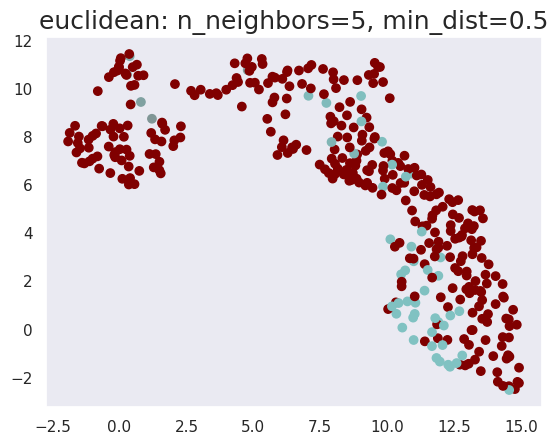

In [20]:
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb_data, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

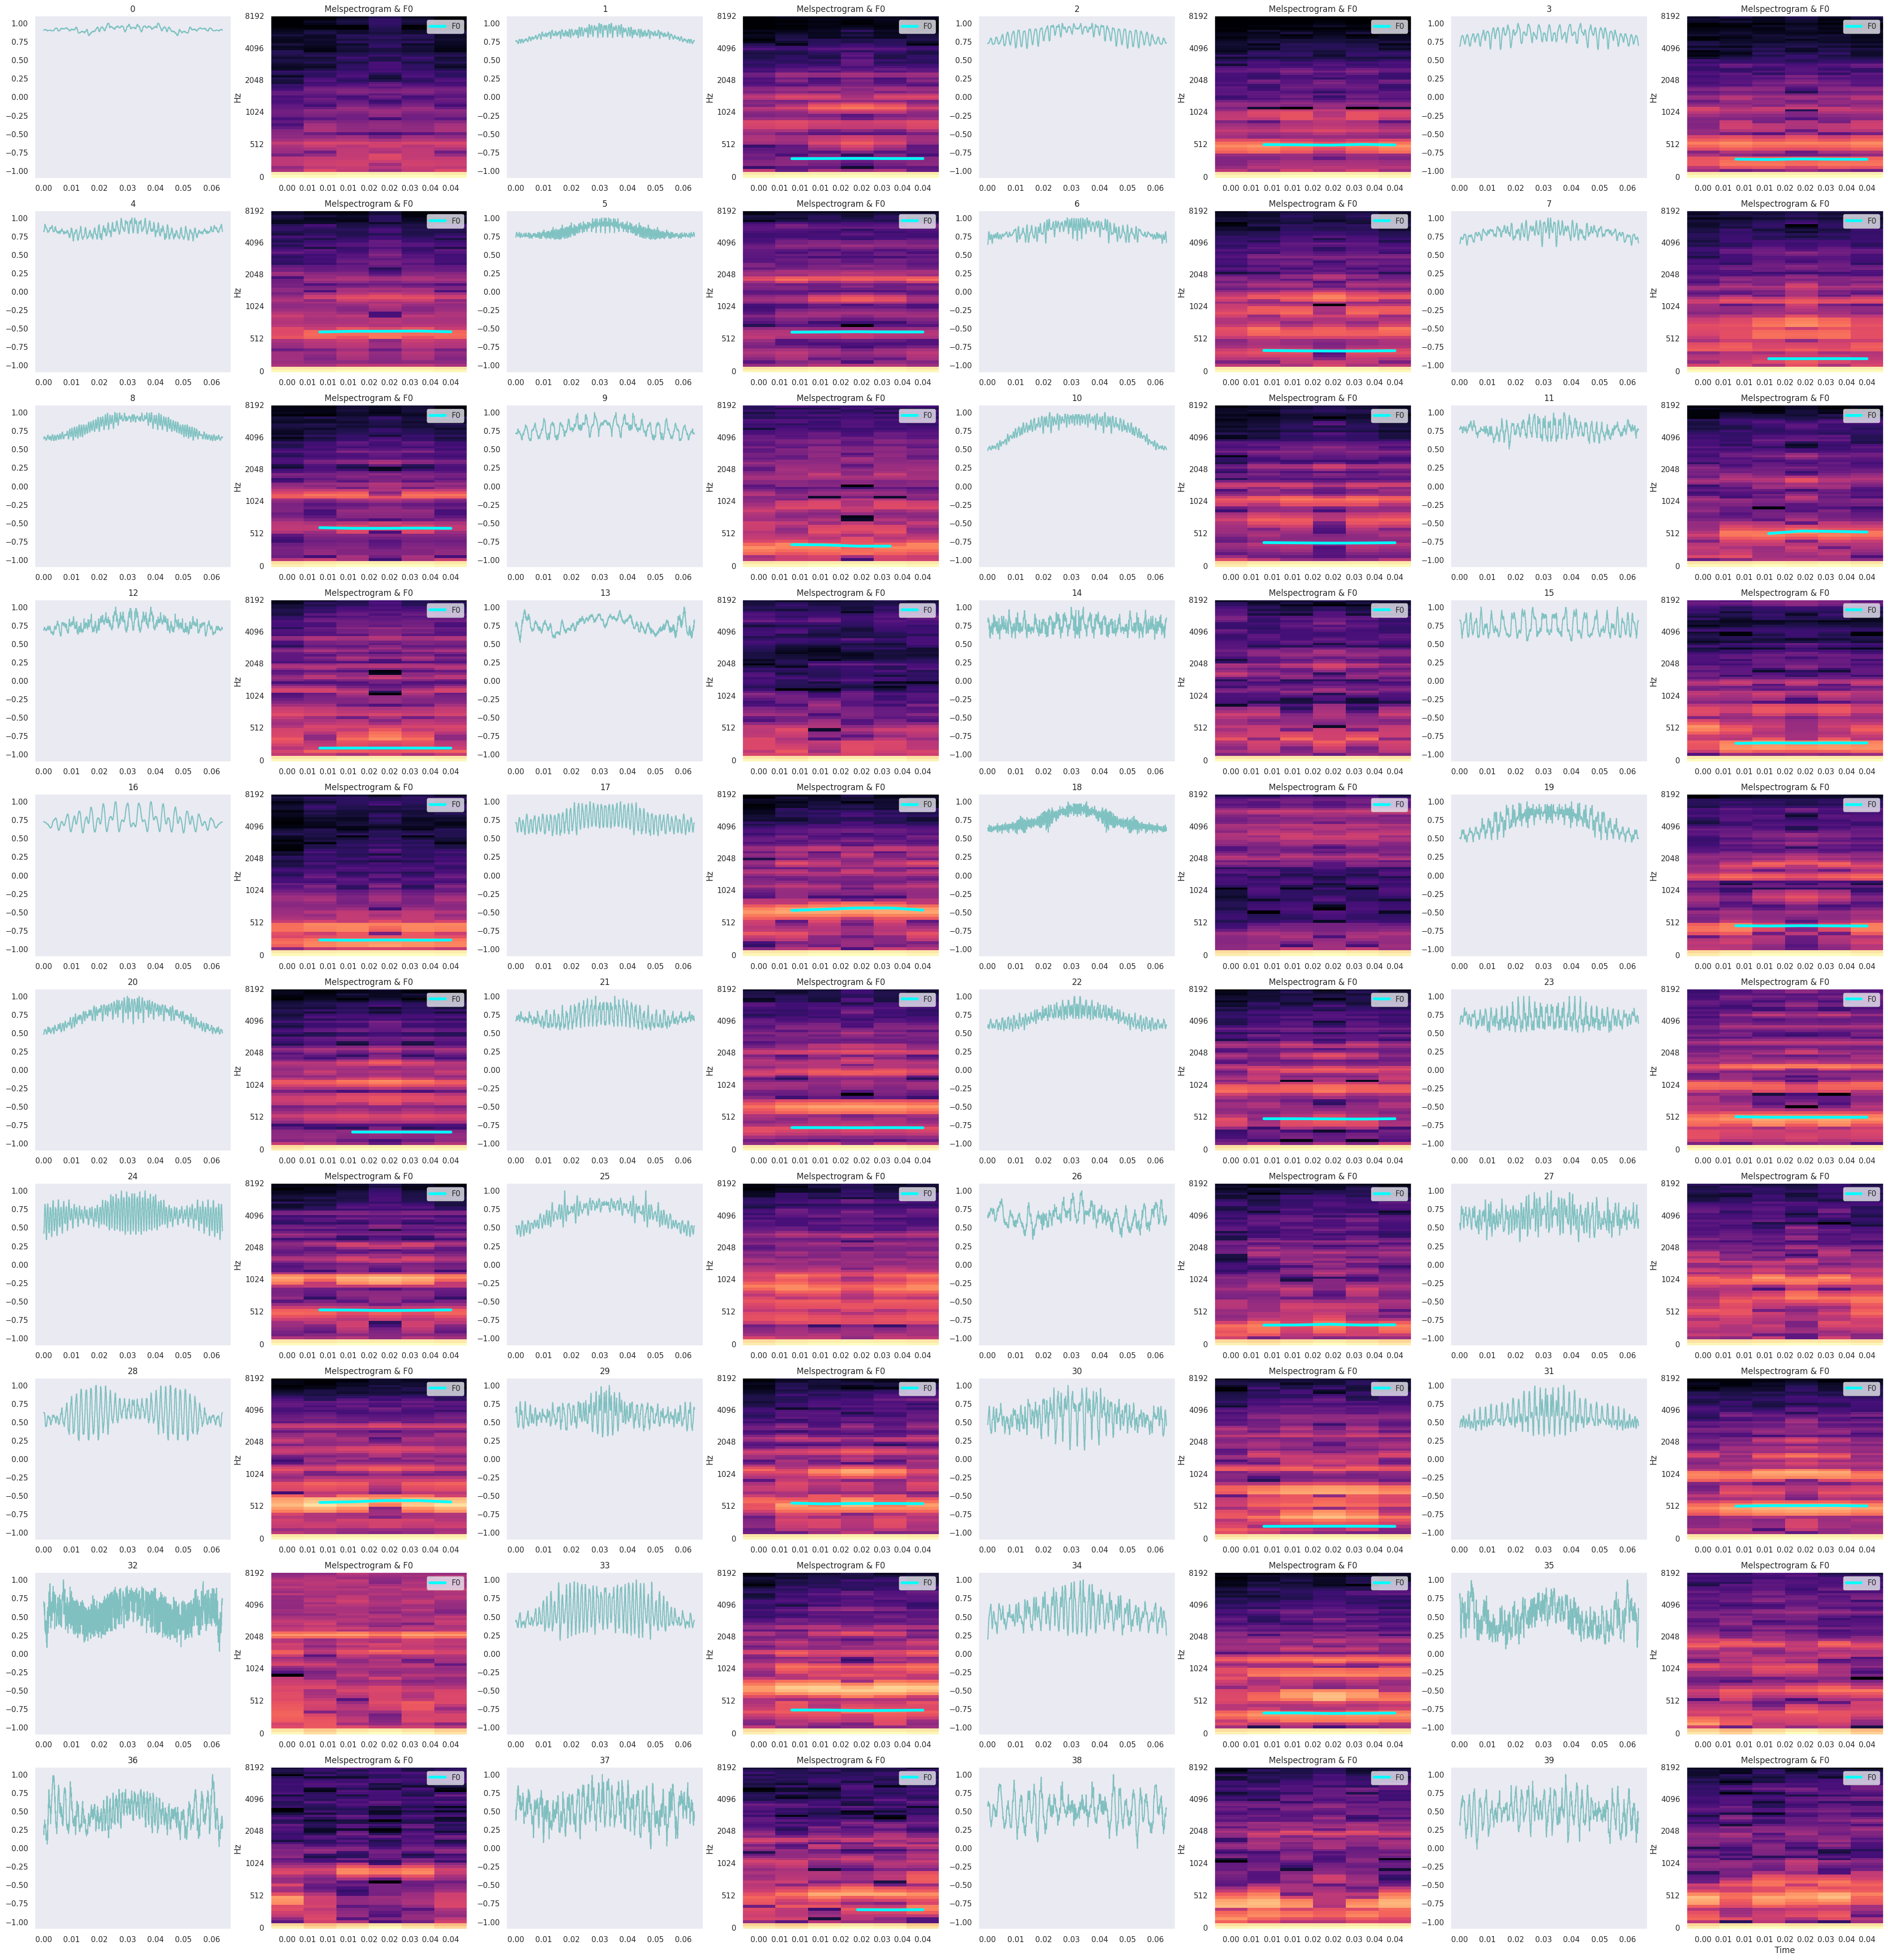

In [21]:
selected_emb_topk = torch.topk(zcs, 40)
selected_idx = selected_emb_topk.indices
visualize_speech_codebook(
    emb_data[selected_idx].numpy(), 
    n=80, colors=emb_color[selected_idx])

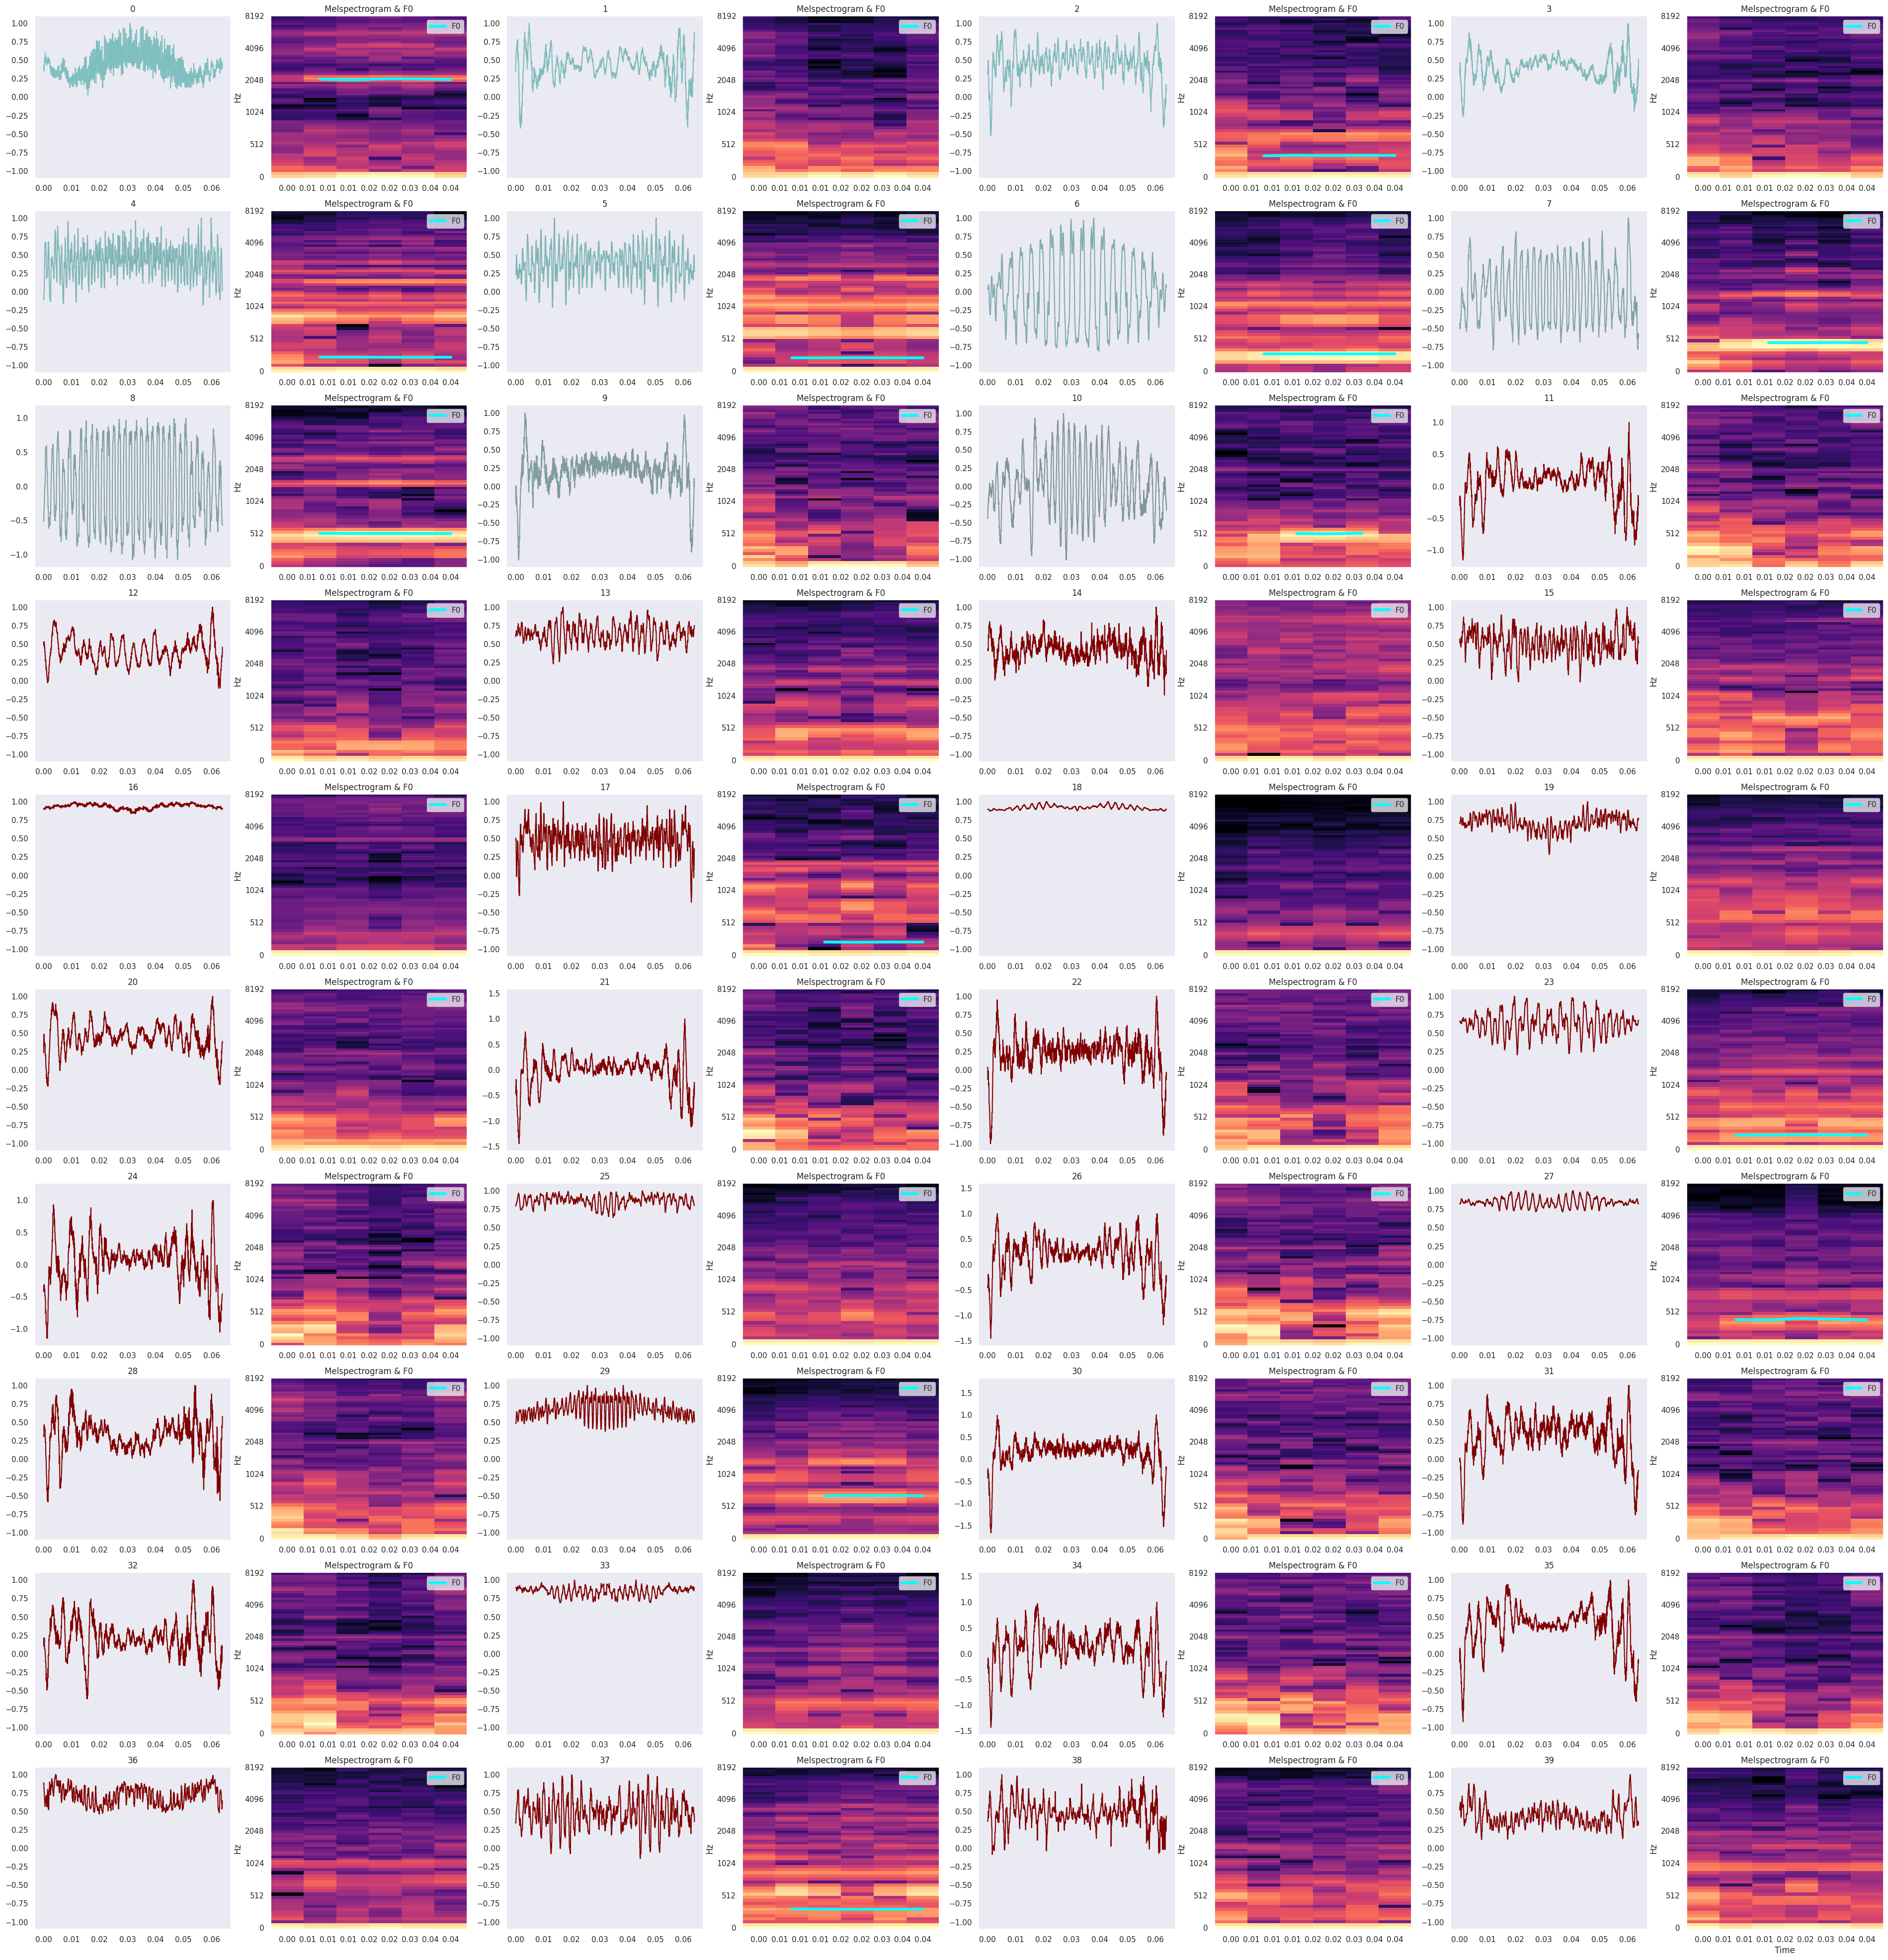

In [22]:
selected_emb_topk = torch.topk(zcs, 80)
selected_idx = selected_emb_topk.indices[-40:]
visualize_speech_codebook(
    emb_data[selected_idx].numpy(), 
    n=80, colors=emb_color[selected_idx])

In [13]:
trainer.fit(n_epoch=n_epoch)

  0%|                                                                                   | 0/4 [00:01<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [4, 384, 233]], which is output 0 of DivBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
metrics, confusion_matrix = trainer.test_step()
pprint(metrics.compute())
confusion_matrix.compute()

In [ ]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2
)

from IConNet.acov.audio_viz import (
    feature_librosa, play_and_visualize, 
    show_feature, compute_pitch, display_audio_list)
from IConNet.acov.audio import AudioLibrosa

from IConNet.firconv.signal import magnitude_to_db

In [ ]:
model = Model(in_channels, out_channels,
              num_embeddings, embedding_dim,
              commitment_cost, num_tokens, 
              num_classes, filter_selection_mode='auto').to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
from IConNet.acov import test_step, train_step, report_metrics

In [ ]:
model.train()
train_recon_error = []
train_perplexity = []
train_cls_loss = []
test_accuracy = []
best_acc = 0

for i in range(num_training_updates):
    (data, target) = next(iter(train_loader))
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()

    logits, vq_loss, recon_loss, perplexity = model(data)
    cls_loss = F.cross_entropy(logits.squeeze(), target)
    loss = vq_loss + recon_loss + 0.15*cls_loss
    loss.backward()
    optimizer.step()

    train_recon_error.append(recon_loss.item())
    train_perplexity.append(perplexity.item())
    train_cls_loss.append(cls_loss.item())

    del data, target
    gc.collect()
    torch.cuda.empty_cache() 

    if (i+1) % log_interval == 0:
        print('%d iterations' % (i+1))
        print('cls_loss: %.3f' % np.mean(train_cls_loss[-log_interval:]))
        print('recon_error: %.3f' % np.mean(train_recon_error[-log_interval:]))
        print('perplexity: %.3f' % np.mean(train_perplexity[-log_interval:]))
        print()

    if (i+1) % test_interval == 0:
        model.eval()
        metrics, confusion_matrix = report_metrics(
            model, test_loader=test_loader,
            labels=labels, device=device)
        confusion_matrix_detail = confusion_matrix.compute()
        num_test_samples = int(confusion_matrix_detail.sum().cpu().numpy())
        t = torch.zeros_like(confusion_matrix_detail)
        torch.eye(t.size(0), out=t)
        pred_correct = int((confusion_matrix_detail*t).sum().cpu().numpy())
        acc = pred_correct/num_test_samples
        print(f'Test iter {i+1}: Accuracy {pred_correct}/{num_test_samples} ({acc*100:.2f}%)')
        test_accuracy.append(acc)
        if acc > best_acc:
            best_acc = acc
            model_path = f'{model_dir}model.{dataset_name}.step{i+1}.pt'
            torch.save(model.state_dict(), model_path)
            metrics_detail = metrics.compute()
            pprint(metrics_detail)
            pprint(confusion_matrix_detail)
        model.train()

In [ ]:
visualize_training_curves(
    test_accuracy, train_res_cls_loss,
    train_res_recon_error, train_res_perplexity
)

In [ ]:
emb_data = model.vq_vae.embedding.weight.data.cpu()
emb_color, zcs = get_embedding_color_v2(emb_data)

In [ ]:
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb_data, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [ ]:
k = 8
min_dist = 0.8
umap_metric = 'euclidean'
visualize_embedding_umap(emb_data, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [ ]:
k = 2
min_dist = 0.99
umap_metric = 'euclidean'
visualize_embedding_umap(emb_data, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [ ]:
k = 8
min_dist = 0.8
umap_metric = 'braycurtis'
visualize_embedding_umap(emb_data, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [ ]:
selected_emb_topk = torch.topk(zcs, 40)
selected_idx = selected_emb_topk.indices
visualize_speech_codebook(
    emb_data[selected_idx].numpy(), 
    n=80, colors=emb_color[selected_idx])

In [ ]:
players = display_audio_list(emb_data3_np, emb3_selected_pidx, f"emb3 ")
for p in players:
    display(p)

In [ ]:
# for g in optimizer.param_groups:
#     g['lr'] = 1e-4

In [ ]:
torch.signal.windows.general_cosine